In [1]:
import numpy as np
from scipy.interpolate import interp1d
from PIL import Image
import matplotlib.pyplot as plt
from scipy.stats import rankdata
from scipy.interpolate import interp1d

In [2]:
def read_im(file):
    """Ensure image in the [0, 1] float format instead of [0, 255] integer."""

    im = plt.imread(file)

    if im.dtype == np.uint8:
        # Convert from [0, 255] uint8 to [0.0, 1.0] float64
        return np.clip(im.astype(np.float64) / 255.0, 0, 1)
    elif im.dtype in [np.float32, np.float64]:
        return np.clip(im, 0.0, 1.0).astype(np.float64)
    else:
        raise Exception("unknown file type")

In [3]:
# images from the paper
source = read_im('imgs/scotland_house.jpeg')
target = read_im('imgs/scotland_plain.jpeg')


# test images from internet
my_source = read_im('imgs/adip-im1.jpg')
my_target = read_im('imgs/adip-im2.jpg') 

In [4]:
# IDT Color Transfer – Assignment Version
# Based on Pitié et al. (2007)

def compute_rotation_matrix(dim=3):
    """Generates a random orthonormal rotation matrix."""
    Q, _ = np.linalg.qr(np.random.randn(dim, dim))
    return Q

def match_1d_cdf(source, target):
    """1D histogram matching via inverse CDF."""
    s_sorted = np.sort(source)
    t_sorted = np.sort(target)
    # Normalized cumulative indices (CDF)
    s_cdf = np.linspace(0, 1, len(s_sorted))
    t_cdf = np.linspace(0, 1, len(t_sorted))

    # Interpolated inverse CDF of target
    inv_cdf = interp1d(t_cdf, t_sorted, bounds_error=False, fill_value=(t_sorted[0], t_sorted[-1]))

    # Map source to percentile and apply inverse target CDF
    source_ranks = rankdata(source, method='average') / len(source)
    return inv_cdf(source_ranks)

def iterative_distribution_transfer(source, target, iterations=10):
    """
    Perform iterative distribution transfer (IDT) to match the color distribution
    of the source image to that of the target.
    """
    u = source.copy()
    for _ in range(iterations):
        R = compute_rotation_matrix(u.shape[1])
        u_rot = u @ R.T
        v_rot = target @ R.T
        for i in range(u.shape[1]):
            u_rot[:, i] = match_1d_cdf(u_rot[:, i], v_rot[:, i])
        u = u_rot @ R  # Transform back
    return u

# apply use
def apply_color_transfer(source_img, target_img, iterations=10):
    """Apply IDT color transfer on two images."""
    src_flat = source_img.reshape(-1, 3)
    tgt_flat = target_img.reshape(-1, 3)
    src_transferred = iterative_distribution_transfer(src_flat, tgt_flat, iterations)
    return src_transferred.reshape(source_img.shape)




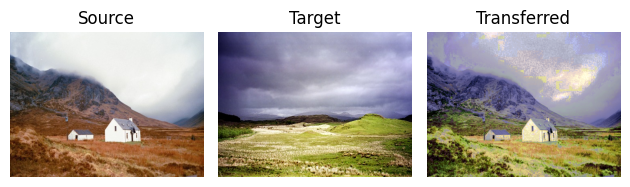

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# color transfer example from paper
result = apply_color_transfer(source, target, iterations=10)

for i, (img, title) in enumerate(zip([source, target, result], ["Source", "Target", "Transferred"]), 1):
    plt.subplot(1, 3, i)
    plt.imshow(np.clip(img, 0, 1))
    plt.title(title)
    plt.axis("off")
plt.tight_layout()
plt.show()

In [20]:
def shift(img):
    """Return four shifted copies of the array in order L, R, U, D.
    Where L, R, U, D are defined as
        L(x, y) = img(x-1, y)
        R(x, y) = img(x+1, y)
        U(x, y) = img(x, y+1)
        D(x, y) = img(x, y-1).
    Because of the intended use in the poisson regraining function,
    the L/R/U/D most row is doubled as to transform interpolation into
    using that only known value and taking derivative 0 at the edge.
    """
    L = np.roll(img, -1, axis=1)
    L[:, 0] = img[:, 0]
    R = np.roll(img, 1, axis=1)
    R[:, -1] = img[:, -1]
    D = np.roll(img, -1, axis=0)
    D[-1, :] = img[-1,:]
    U = np.roll(img, 1, axis=0)
    U[0, :] = img[0, :]

    return L, R, U, D


In [21]:
shift(np.array([[1, 2], [3, 4]]))

(array([[1, 1],
        [3, 3]]),
 array([[2, 2],
        [4, 4]]),
 array([[1, 2],
        [1, 2]]),
 array([[3, 4],
        [3, 4]]))

In [84]:


def poisson_regrain(original, transferred, initial_guess="transferred", num_iters=100, tolerance=1e-3):
    
    J = np.zeros_like(original, dtype=np.float64)

    for c in range(3):
        I = original[:, :, c]
        tI = transferred[:, :, c]

        # Compute gradient
        gy, gx = np.gradient(I.astype('float64'))
        # factor 255 to reproduce the 0 to 255 scaling of the paper
        grad_I = np.sqrt(gx**2 + gy**2)

        # original gradient matching
        phi = 30 / (1 + 10 * grad_I)
        # transferred colour matching
        psi = np.where(grad_I < 5, grad_I / 5, 1)

        # Shifted phi
        phi_left, phi_right, phi_up, phi_down = shift(phi)

        # Coefficients
        a1 = -(phi_down + phi) / 2
        a2 = -(phi_up + phi) / 2
        a3 = -(phi_left + phi) / 2
        a4 = -(phi_right + phi) / 2
        a5 = 0.5 * (4 * phi + phi_up + phi_down + phi_left + phi_right) + psi

        # Shifted I
        I_left, I_right, I_up, I_down = shift(I)

        a6 = - 0.5 * ((phi + phi_up) * (I_up - I) +
                    (phi + phi_down) * (I_down - I) +
                    (phi + phi_left) * (I_left - I) +
                    (phi + phi_right) * (I_right - I)) + psi * tI

        # Initial guess
        if initial_guess == "transferred":
            J_old = tI.copy()
        elif initial_guess == "zeros":
            J_old = np.zeros_like(I)
        elif initial_guess == "original":
            J_old = I.copy()
        else:
            raise Exception("invalid initial guess (transferred, zeros, original)")

        for i in range(num_iters):

            J_left, J_right, J_up, J_down = shift(J_old)

            J_new = (1 / a5) * (
                a6
                - a1 * J_down
                - a2 * J_up
                - a3 * J_left
                - a4 * J_right
            )

            # Neumann BCs to preserve I's gradient at edges
            J_new[0, 1:-1] = J_new[1, 1:-1] + (I[0, 1:-1] - I[1, 1:-1])
            J_new[-1, 1:-1] = J_new[-2, 1:-1] + (I[-1, 1:-1] - I[-2, 1:-1])
            J_new[1:-1, 0] = J_new[1:-1, 1] + (I[1:-1, 0] - I[1:-1, 1])
            J_new[1:-1, -1] = J_new[1:-1, -2] + (I[1:-1, -1] - I[1:-1, -2])

            # check if the image is changing from iteration to iteraction
            if np.sum( (J_old - J_new)**2 ) < tolerance:
                print(f"tolerance reached after {i} iterations")
                break

            J_old = J_new

        J[:, :, c] = J_new

    return J


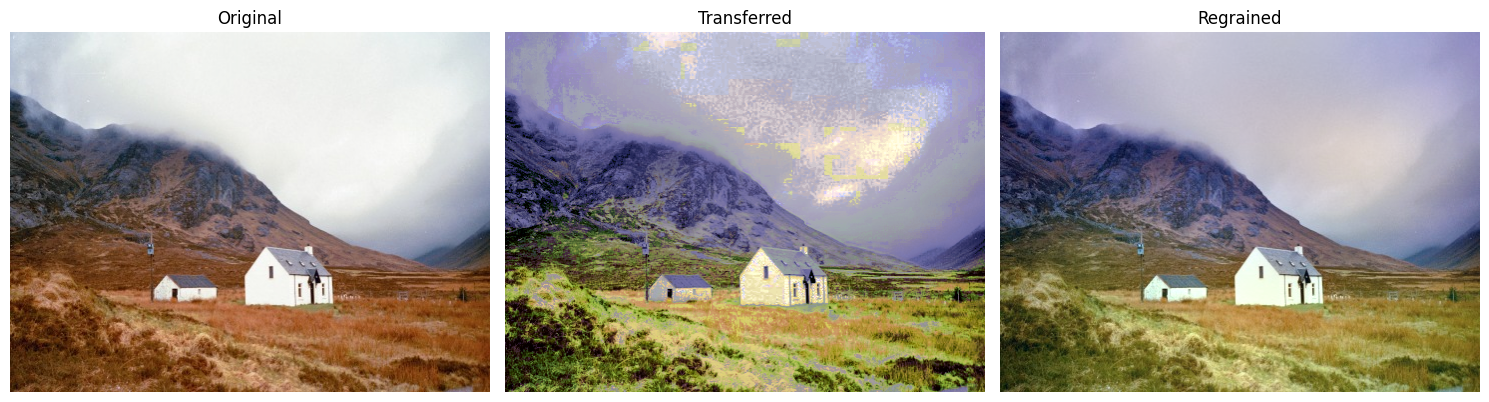

In [85]:
regrained = poisson_regrain(source, result, initial_guess="transferred", num_iters=2000)

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
for i, (img, title) in enumerate(
    zip([source, result, regrained], ["Original", "Transferred", "Regrained"]), 1):
    plt.subplot(1, 3, i)
    plt.imshow(np.clip(img, 0, 1))
    plt.title(title)
    plt.axis("off")
plt.tight_layout()
plt.show()


